Quy trình thực hiện:
- Huấn luyện mô hình YOLOv8 cho Number Plate Detection và Vehicle Detection


- Trích xuất các frame từ video, sử dụng YOLO để detect đối tượng và sử dụng mô hình phân lớp phía trên để phân loại.

- Ghép các frame đã được sử lí lại thành video hoàn chỉnh có chú thích.

**Bộ data huấn luyện mô hình phân loại cho 3 lớp: Đội mũ, không đội mũ và quá tải.**

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.4/904.4 kB 16.7 MB/s eta 0:00:00


In [ ]:
!pip install pytesseract

In [ ]:
!pip install supervision opencv-python-headless
!pip install onemetric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.5 MB/s eta 0:00:00


In [ ]:
!pip install deep_sort_realtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 34.3 MB/s eta 0:00:00


In [ ]:
import torch.nn as nn
import torch
import json
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
import yaml
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import random
from deep_sort_realtime.deepsort_tracker import DeepSort
import pytesseract

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Number plate detection

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("duydieunguyen/licenseplates")

print("Path to dataset files:", path)

100%|██████████| 959M/959M [00:10<00:00, 99.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/duydieunguyen/licenseplates/versions/1


In [ ]:
# check path
print(os.listdir('/root/.cache/kagglehub/datasets/duydieunguyen/licenseplates/versions/1/'))

['labels', 'images', 'dataset.yaml']


In [ ]:
data_yaml = {
    'train': '/root/.cache/kagglehub/datasets/duydieunguyen/licenseplates/versions/1/images/train',
    'val': '/root/.cache/kagglehub/datasets/duydieunguyen/licenseplates/versions/1/images/val',
    'names': ['BSD', 'BSV']
}

with open('/root/.cache/kagglehub/datasets/duydieunguyen/licenseplates/versions/1/data.yaml', 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

In [ ]:
model = YOLO('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:00<00:00, 153MB/s]


In [ ]:
model.train(data='/root/.cache/kagglehub/datasets/duydieunguyen/licenseplates/versions/1/data.yaml',
    epochs=20,
    batch=16,
    imgsz=640,
    mosaic=1.0,                        # Mức độ áp dụng Mosaic augmentation
    hsv_h=0.015,                       # Điều chỉnh Hue
    hsv_s=0.7,                         # Điều chỉnh Saturation
    hsv_v=0.4,                         # Điều chỉnh Brightness
    degrees=10.0,                      # Góc xoay
    translate=0.1,                     # Tịnh tiến
    scale=0.5,                         # Phóng to/thu nhỏ
    shear=0.1
    )

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/root/.cache/kagglehub/datasets/duydieunguyen/licenseplates/versions/1/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cr

100%|██████████| 755k/755k [00:00<00:00, 24.0MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 101MB/s]


AMP: checks passed ✅


train: Scanning /root/.cache/kagglehub/datasets/duydieunguyen/licenseplates/versions/1/labels/train... 3433 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3433/3433 [00:03<00:00, 1139.09it/s]


train: New cache created: /root/.cache/kagglehub/datasets/duydieunguyen/licenseplates/versions/1/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /root/.cache/kagglehub/datasets/duydieunguyen/licenseplates/versions/1/labels/val... 1145 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1145/1145 [00:03<00:00, 368.45it/s]


val: New cache created: /root/.cache/kagglehub/datasets/duydieunguyen/licenseplates/versions/1/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.79G     0.6912     0.9007      0.968         23        640: 100%|██████████| 215/215 [02:08<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:20<00:00,  1.76it/s]

                   all       1145       1313      0.939      0.897       0.95      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.84G     0.7419     0.6162     0.9814         20        640: 100%|██████████| 215/215 [02:03<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:17<00:00,  2.01it/s]

                   all       1145       1313      0.939       0.93      0.961      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.73G     0.7465     0.5701     0.9847         18        640: 100%|██████████| 215/215 [02:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:18<00:00,  1.90it/s]

                   all       1145       1313      0.931      0.928      0.975      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.83G     0.6997     0.5219     0.9613         11        640: 100%|██████████| 215/215 [02:02<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:18<00:00,  1.92it/s]

                   all       1145       1313      0.977      0.948      0.983      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.83G     0.6549     0.4743      0.941         22        640: 100%|██████████| 215/215 [02:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:17<00:00,  2.04it/s]

                   all       1145       1313      0.974      0.929      0.981       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.84G     0.6529     0.4589      0.943         25        640: 100%|██████████| 215/215 [02:03<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:18<00:00,  1.99it/s]

                   all       1145       1313      0.972      0.944       0.98      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.74G     0.6325     0.4309     0.9335         19        640: 100%|██████████| 215/215 [02:06<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:18<00:00,  1.99it/s]

                   all       1145       1313      0.973      0.951      0.984       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.82G     0.6175     0.4073     0.9291         22        640: 100%|██████████| 215/215 [02:03<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:19<00:00,  1.85it/s]

                   all       1145       1313      0.977      0.949      0.989      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.82G     0.5966      0.404     0.9188         20        640: 100%|██████████| 215/215 [02:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:18<00:00,  1.96it/s]

                   all       1145       1313      0.969       0.97      0.989      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.83G     0.5879     0.3797     0.9164         14        640: 100%|██████████| 215/215 [02:10<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:18<00:00,  1.98it/s]

                   all       1145       1313      0.985       0.97      0.993      0.864


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.73G     0.5656     0.3472      0.929          9        640: 100%|██████████| 215/215 [02:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:18<00:00,  1.95it/s]

                   all       1145       1313      0.971      0.971       0.99      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.83G     0.5676      0.341     0.9251          9        640: 100%|██████████| 215/215 [02:00<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:18<00:00,  1.97it/s]

                   all       1145       1313      0.971      0.975       0.99      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.83G     0.5499     0.3228     0.9201          9        640: 100%|██████████| 215/215 [02:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:17<00:00,  2.00it/s]

                   all       1145       1313      0.986      0.969      0.993      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.84G     0.5358     0.3087      0.908          9        640: 100%|██████████| 215/215 [01:59<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]

                   all       1145       1313      0.989      0.973      0.993      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.73G     0.5294     0.2996       0.91          9        640: 100%|██████████| 215/215 [02:00<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:19<00:00,  1.82it/s]

                   all       1145       1313      0.975      0.978      0.993      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.83G     0.5159     0.2878     0.8967         10        640: 100%|██████████| 215/215 [01:59<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]

                   all       1145       1313      0.984      0.981      0.993      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.83G     0.5037     0.2746     0.8868         11        640: 100%|██████████| 215/215 [02:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:21<00:00,  1.66it/s]

                   all       1145       1313      0.984      0.982      0.994      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.84G     0.4922      0.266     0.8855         10        640: 100%|██████████| 215/215 [02:08<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:20<00:00,  1.75it/s]

                   all       1145       1313      0.974      0.987      0.994      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.73G     0.4826     0.2517     0.8774         14        640: 100%|██████████| 215/215 [02:05<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:18<00:00,  1.99it/s]

                   all       1145       1313       0.98      0.988      0.994      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.82G     0.4706     0.2413      0.874         11        640: 100%|██████████| 215/215 [02:06<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:17<00:00,  2.04it/s]

                   all       1145       1313      0.982      0.988      0.994      0.901



20 epochs completed in 0.807 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:20<00:00,  1.73it/s]


                   all       1145       1313      0.982      0.988      0.994      0.901
                   BSD        409        410      0.989      0.993      0.995      0.891
                   BSV        753        903      0.975      0.983      0.993      0.911
Speed: 0.2ms preprocess, 7.7ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ab487765ea0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

# For vehicle classification

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sakshamjn/vehicle-detection-8-classes-object-detection")

print("Path to dataset files:", path)

100%|██████████| 346M/346M [00:04<00:00, 72.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sakshamjn/vehicle-detection-8-classes-object-detection/versions/1


In [ ]:
def print_tree(directory, level=0):
    if not os.path.exists(directory):
        print(f"Path {directory} does not exist.")
        return

    files = os.listdir(directory)
    files.sort()

    num_files = sum(1 for f in files if os.path.isfile(os.path.join(directory, f)))

    for index, file in enumerate(files):
        path = os.path.join(directory, file)
        if os.path.isdir(path):
            print("  " * level + f"|--- {file}")
            print_tree(path, level + 1)
        else:
            if num_files > 1 and index == 0:
                print("  " * level + f"|--- {file}")
            elif num_files > 1 and index == 1:
                print("  " * level + f"|--- ...")
                break
            else:
                print("  " * level + f"|--- {file}")

print_tree('/root/.cache/kagglehub/datasets/sakshamjn/vehicle-detection-8-classes-object-detection/versions/1/train')

|--- images
  |--- Highway_0_2020-07-30_jpg.rf.09e9d4467f17b2b870a5d1b94a38774a.jpg
  |--- ...
|--- labels
  |--- Highway_0_2020-07-30_jpg.rf.09e9d4467f17b2b870a5d1b94a38774a.txt
  |--- ...
|--- labels.npy


Labels:

In [ ]:
!cat /root/.cache/kagglehub/datasets/sakshamjn/vehicle-detection-8-classes-object-detection/versions/1/train/labels/classes.txt

auto
bus
car
lcv
motorcycle
multiaxle
tractor
truck

## Create data format for YOLO


In [ ]:
!mkdir working

In [ ]:
cd working

/content/working


In [ ]:
!mkdir dataset

In [ ]:
cd dataset

/content/working/dataset


Xử lí data

In [ ]:
def process_labels(label_folder, class_mapping):
    for label_file in os.listdir(label_folder):
        if label_file.endswith('.txt'):
            file_path = os.path.join(label_folder, label_file)

            with open(file_path, 'r') as f:
                lines = f.readlines()

            updated_lines = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) > 0:
                    class_id = int(parts[0])
                    if class_id in class_mapping:
                        parts[0] = str(class_mapping[class_id])
                    updated_lines.append(' '.join(parts))

            with open(file_path, 'w') as f:
                f.write('\n'.join(updated_lines))

### Format data 1

In [ ]:
source_images = '/root/.cache/kagglehub/datasets/sakshamjn/vehicle-detection-8-classes-object-detection/versions/1/train/images'
source_labels = '/root/.cache/kagglehub/datasets/sakshamjn/vehicle-detection-8-classes-object-detection/versions/1/train/labels'
destination_root = '/working/dataset'

os.makedirs(os.path.join(destination_root, 'train/images'), exist_ok=True)
os.makedirs(os.path.join(destination_root, 'train/labels'), exist_ok=True)
os.makedirs(os.path.join(destination_root, 'test/images'), exist_ok=True)
os.makedirs(os.path.join(destination_root, 'test/labels'), exist_ok=True)

images = [f for f in os.listdir(source_images) if f.endswith('.jpg')]
labels = [f.replace('.jpg', '.txt') for f in images]

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

for img, lbl in zip(train_images, train_labels):
    shutil.copy(os.path.join(source_images, img), os.path.join(destination_root, 'train/images', img))
    shutil.copy(os.path.join(source_labels, lbl), os.path.join(destination_root, 'train/labels', lbl))

for img, lbl in zip(test_images, test_labels):
    shutil.copy(os.path.join(source_images, img), os.path.join(destination_root, 'test/images', img))
    shutil.copy(os.path.join(source_labels, lbl), os.path.join(destination_root, 'test/labels', lbl))

### Format data 2

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saumyapatel/traffic-vehicles-object-detection")

print("Path to dataset files:", path)

100%|██████████| 607M/607M [00:08<00:00, 76.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/saumyapatel/traffic-vehicles-object-detection/versions/1


Đổi tên class của các bounding box

In [ ]:
class_mapping_1 = {0: 2, 1: 9, 2: 10, 3: 4, 4: 0, 5: 1, 6: 7}

In [ ]:
folders_to_process = ['train', 'val']
root_folder = '/root/.cache/kagglehub/datasets/saumyapatel/traffic-vehicles-object-detection/versions/1/Traffic Dataset/labels'
# Duyệt qua từng thư mục con và xử lý
for folder in folders_to_process:
    label_folder = os.path.join(root_folder, folder)
    if os.path.exists(label_folder):
        process_labels(label_folder, class_mapping_1)
    else:
        print(f"Folder {label_folder} không tồn tại!")

Di chuyển và tổ chức file

In [ ]:
source_images_train = '/root/.cache/kagglehub/datasets/saumyapatel/traffic-vehicles-object-detection/versions/1/Traffic Dataset/images/train'
source_images_test = '/root/.cache/kagglehub/datasets/saumyapatel/traffic-vehicles-object-detection/versions/1/Traffic Dataset/images/val'
source_labels_train = '/root/.cache/kagglehub/datasets/saumyapatel/traffic-vehicles-object-detection/versions/1/Traffic Dataset/labels/train'
source_labels_test = '/root/.cache/kagglehub/datasets/saumyapatel/traffic-vehicles-object-detection/versions/1/Traffic Dataset/labels/val'
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

For train

In [ ]:
train_images = [f for f in os.listdir(source_images_train) if f.endswith(valid_extensions)]
train_labels = [os.path.splitext(f)[0] + '.txt' for f in train_images]
for img, lbl in zip(train_images, train_labels):
    shutil.copy(os.path.join(source_images_train, img), os.path.join(destination_root, 'train/images', img))
    shutil.copy(os.path.join(source_labels_train, lbl), os.path.join(destination_root, 'train/labels', lbl))

For test

In [ ]:
test_images = [f for f in os.listdir(source_images_test) if f.endswith(valid_extensions)]
test_labels = [os.path.splitext(f)[0] + '.txt' for f in test_images]
for img, lbl in zip(test_images, test_labels):
    shutil.copy(os.path.join(source_images_test, img), os.path.join(destination_root, 'test/images', img))
    shutil.copy(os.path.join(source_labels_test, lbl), os.path.join(destination_root, 'test/labels', lbl))

### Format data 3

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alkanerturan/vehicledetection")

print("Path to dataset files:", path)

100%|██████████| 62.8M/62.8M [00:00<00:00, 78.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alkanerturan/vehicledetection/versions/3


Đổi tên class cho các bounding box

In [ ]:
class_mapping_2 = {0: 8, 3: 4, 4: 7}

In [ ]:
folders_to_process = ['train/labels', 'valid/labels']
root_folder = '/root/.cache/kagglehub/datasets/alkanerturan/vehicledetection/versions/3/VehiclesDetectionDataset'
# Duyệt qua từng thư mục con và xử lý
for folder in folders_to_process:
    label_folder = os.path.join(root_folder, folder)
    if os.path.exists(label_folder):
        process_labels(label_folder, class_mapping_2)
    else:
        print(f"Folder {label_folder} không tồn tại!")

Di chuyển và tổ chức lại file

In [ ]:
source_images_train = '/root/.cache/kagglehub/datasets/alkanerturan/vehicledetection/versions/3/VehiclesDetectionDataset/train/images'
source_images_test = '/root/.cache/kagglehub/datasets/alkanerturan/vehicledetection/versions/3/VehiclesDetectionDataset/valid/images'
source_labels_train = '/root/.cache/kagglehub/datasets/alkanerturan/vehicledetection/versions/3/VehiclesDetectionDataset/train/labels'
source_labels_test = '/root/.cache/kagglehub/datasets/alkanerturan/vehicledetection/versions/3/VehiclesDetectionDataset/valid/labels'
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

for train

In [ ]:
train_images = [f for f in os.listdir(source_images_train) if f.endswith(valid_extensions)]
train_labels = [os.path.splitext(f)[0] + '.txt' for f in train_images]
for img, lbl in zip(train_images, train_labels):
    shutil.copy(os.path.join(source_images_train, img), os.path.join(destination_root, 'train/images', img))
    shutil.copy(os.path.join(source_labels_train, lbl), os.path.join(destination_root, 'train/labels', lbl))

for test

In [ ]:
test_images = [f for f in os.listdir(source_images_test) if f.endswith(valid_extensions)]
test_labels = [os.path.splitext(f)[0] + '.txt' for f in test_images]
for img, lbl in zip(test_images, test_labels):
    shutil.copy(os.path.join(source_images_test, img), os.path.join(destination_root, 'test/images', img))
    shutil.copy(os.path.join(source_labels_test, lbl), os.path.join(destination_root, 'test/labels', lbl))

Cấu trúc data_yaml

In [ ]:
data_yaml = {
    'train': '/working/dataset/train/images',
    'val': '/working/dataset/test/images',
    'names': ['auto', 'bus', 'car', 'lcv', 'motorcycle', 'multiaxle', 'tractor', 'truck', 'ambulance', 'number_plate', 'blur_number_plate']
}

with open('/working/dataset/data.yaml', 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

In [ ]:
model = YOLO('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:00<00:00, 363MB/s]


In [ ]:
model.train(data='/working/dataset/data.yaml',
    epochs=20,
    batch=16,
    imgsz=640,
    mosaic=1.0,                        # Mức độ áp dụng Mosaic augmentation
    hsv_h=0.015,                       # Điều chỉnh Hue
    hsv_s=0.7,                         # Điều chỉnh Saturation
    hsv_v=0.4,                         # Điều chỉnh Brightness
    degrees=10.0,                      # Góc xoay
    translate=0.1,                     # Tịnh tiến
    scale=0.5,                         # Phóng to/thu nhỏ
    shear=0.1
    )

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/working/dataset/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

100%|██████████| 755k/755k [00:00<00:00, 23.9MB/s]


Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 108MB/s]


AMP: checks passed ✅


train: Scanning /working/dataset/train/labels... 8190 images, 21 backgrounds, 0 corrupt: 100%|██████████| 8190/8190 [00:04<00:00, 1872.62it/s]

train: WARNING ⚠️ /working/dataset/train/images/00 (453).jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /working/dataset/train/images/00 (837).jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /working/dataset/train/images/00 (857).jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /working/dataset/train/images/highway_2784_2020-08-26.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /working/dataset/train/images/highway_3297_2020-08-26.jpg: 1 duplicate labels removed


train: New cache created: /working/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /working/dataset/test/labels... 2079 images, 4 backgrounds, 0 corrupt: 100%|██████████| 2079/2079 [00:01<00:00, 1115.70it/s]


val: New cache created: /working/dataset/test/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.91G      1.393      1.452      1.265         75        640: 100%|██████████| 512/512 [04:42<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:31<00:00,  2.07it/s]


                   all       2079       7571       0.45      0.507      0.425      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.78G      1.359      1.207      1.265         61        640: 100%|██████████| 512/512 [04:41<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:30<00:00,  2.12it/s]


                   all       2079       7571      0.458      0.559      0.453      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.85G      1.353      1.183      1.266         88        640: 100%|██████████| 512/512 [04:39<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:30<00:00,  2.11it/s]


                   all       2079       7571       0.44      0.575      0.505      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.97G      1.323      1.124      1.248        116        640: 100%|██████████| 512/512 [04:38<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:30<00:00,  2.11it/s]


                   all       2079       7571      0.528      0.617      0.571      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.85G      1.283      1.062      1.227        143        640: 100%|██████████| 512/512 [04:40<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:29<00:00,  2.20it/s]


                   all       2079       7571      0.541      0.656      0.618      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.89G      1.258      1.021      1.217         73        640: 100%|██████████| 512/512 [04:39<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:29<00:00,  2.18it/s]

                   all       2079       7571      0.609      0.642      0.633      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.94G      1.223     0.9722      1.192         76        640: 100%|██████████| 512/512 [04:37<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:30<00:00,  2.13it/s]

                   all       2079       7571      0.603      0.708       0.68      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.81G      1.205     0.9462      1.187        121        640: 100%|██████████| 512/512 [04:39<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:29<00:00,  2.17it/s]


                   all       2079       7571      0.606      0.709       0.69      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.87G      1.179      0.912      1.172         78        640: 100%|██████████| 512/512 [04:36<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:30<00:00,  2.12it/s]

                   all       2079       7571      0.664      0.681      0.694      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.86G      1.167       0.89      1.163         58        640: 100%|██████████| 512/512 [04:37<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:30<00:00,  2.16it/s]

                   all       2079       7571      0.646      0.671      0.695      0.447


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.95G      1.165     0.8131      1.177        111        640: 100%|██████████| 512/512 [04:35<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:30<00:00,  2.14it/s]

                   all       2079       7571      0.606      0.738      0.709      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.94G      1.137     0.7774       1.16         58        640: 100%|██████████| 512/512 [04:35<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:29<00:00,  2.19it/s]

                   all       2079       7571      0.642      0.675      0.698      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.86G      1.124     0.7545      1.154         67        640: 100%|██████████| 512/512 [04:34<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:30<00:00,  2.13it/s]

                   all       2079       7571      0.691        0.7      0.736      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.87G      1.101     0.7317      1.142         58        640: 100%|██████████| 512/512 [04:34<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:30<00:00,  2.15it/s]

                   all       2079       7571      0.686      0.713      0.752      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       6.9G      1.077     0.7024      1.127         57        640: 100%|██████████| 512/512 [04:34<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:30<00:00,  2.11it/s]

                   all       2079       7571      0.727      0.704      0.757       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.85G      1.065     0.6804      1.124         31        640: 100%|██████████| 512/512 [04:35<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:30<00:00,  2.11it/s]

                   all       2079       7571       0.71      0.717      0.769      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.94G      1.043     0.6504      1.106         40        640: 100%|██████████| 512/512 [04:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:30<00:00,  2.14it/s]

                   all       2079       7571      0.712      0.743      0.772      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.84G      1.031     0.6291      1.101         35        640: 100%|██████████| 512/512 [04:35<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:30<00:00,  2.14it/s]

                   all       2079       7571      0.762      0.719      0.792      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.94G       1.01     0.6102      1.092         52        640: 100%|██████████| 512/512 [04:34<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:30<00:00,  2.15it/s]

                   all       2079       7571      0.769      0.727      0.793      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.87G     0.9929     0.5835      1.082         54        640: 100%|██████████| 512/512 [04:34<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:29<00:00,  2.19it/s]

                   all       2079       7571      0.744      0.746      0.793      0.551



20 epochs completed in 1.739 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,846,129 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:34<00:00,  1.90it/s]


                   all       2079       7571      0.743      0.745      0.793      0.551
                  auto        176        238      0.773      0.702      0.742      0.436
                   bus        372        418      0.755      0.818      0.841      0.645
                   car       1405       3533      0.877      0.881      0.926      0.684
                   lcv        203        206      0.611      0.565      0.641      0.474
            motorcycle        952       1759      0.801      0.796      0.859      0.502
             multiaxle        202        215      0.605      0.707      0.749      0.592
               tractor         31         31      0.778      0.903      0.885      0.636
                 truck        620        772      0.695      0.725      0.747      0.551
             ambulance         50         64      0.563      0.875      0.819      0.699
          number_plate        104        174      0.749      0.859      0.841      0.497
     blur_number_plat

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ed8c41bd450>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.


image 1/1 /working/dataset/test/images/highway_3156_2020-08-26.jpg: 640x640 1 truck, 37.0ms
Speed: 1.8ms preprocess, 37.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /working/dataset/test/images/00 (807).jpg: 288x640 5 autos, 18 cars, 11 motorcycles, 42.8ms
Speed: 1.5ms preprocess, 42.8ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /working/dataset/test/images/ulu838_jpg.rf.3d19c194204245f704b797112c4a69a3.jpg: 640x640 2 cars, 1 motorcycle, 1 truck, 37.2ms
Speed: 2.3ms preprocess, 37.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



<ipython-input-53-b12945749a39>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf = float(pred.conf.cpu().numpy())
<ipython-input-53-b12945749a39>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_id = int(pred.cls.cpu().numpy())


image 1/1 /working/dataset/test/images/ulu776_jpg.rf.bfb3d81f1c971459c16eebcb319a70bc.jpg: 640x640 2 cars, 2 motorcycles, 33.4ms
Speed: 2.2ms preprocess, 33.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /working/dataset/test/images/Highway_1105_2020-07-30_jpg.rf.886dcbf0092fdbb21cecdee9b714c7d0.jpg: 640x640 3 cars, 1 tractor, 33.7ms
Speed: 4.4ms preprocess, 33.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


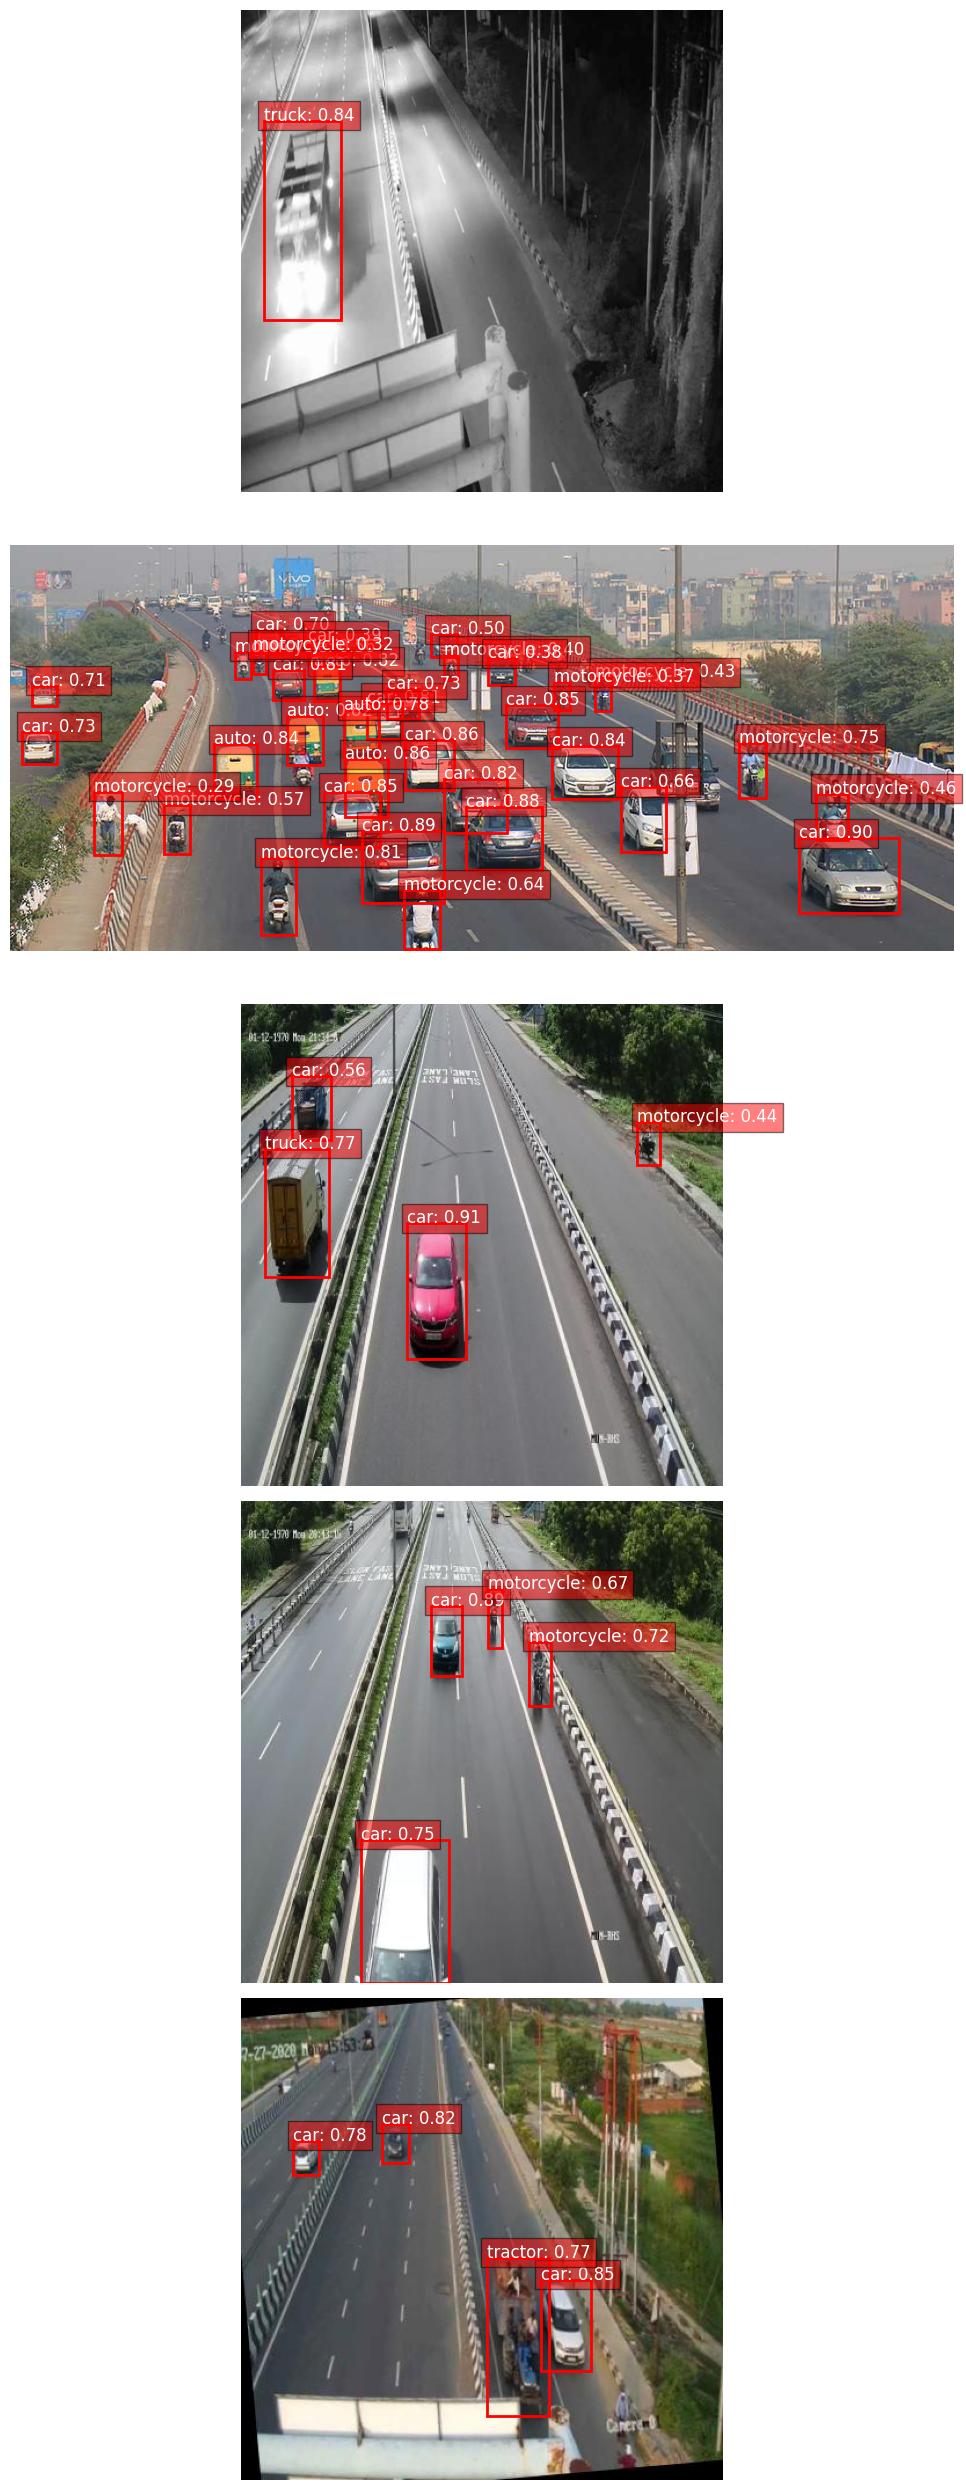

In [ ]:
model = YOLO('/content/working/dataset/runs/detect/train/weights/best.pt')
test_image_dir = '/working/dataset/test/images'
test_images = os.listdir(test_image_dir)
test_images = [img for img in test_images if img.endswith('.jpg')]
sample_images = random.sample(test_images, 5)

fig, axes = plt.subplots(len(sample_images), 1, figsize=(10, len(sample_images) * 5))

for i, image_name in enumerate(sample_images):
    image_path = os.path.join(test_image_dir, image_name)
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = model(image_path)
    axes[i].imshow(img_rgb)
    axes[i].axis('off')

    for pred in results[0].boxes:
        x1, y1, x2, y2 = pred.xyxy[0].cpu().numpy()
        conf = float(pred.conf.cpu().numpy())
        class_id = int(pred.cls.cpu().numpy())
        label = model.names[class_id]

        axes[i].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2))
        axes[i].text(x1, y1, f'{label}: {conf:.2f}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

plt.tight_layout()
plt.show()

# For two-wheelers violation detection

In [ ]:
import os
import cv2
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from glob import glob
from PIL import Image
from torchvision.models import convnext_small, ConvNeXt_Small_Weights

In [ ]:
from tqdm import tqdm

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meliodassourav/traffic-violation-dataset-v3")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/meliodassourav/traffic-violation-dataset-v3/versions/1


In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),          # Resize ảnh về 224x224
    transforms.ToTensor(),                  # Chuyển ảnh thành Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa
])

In [ ]:
label_mapping = {
    "helmet": 0,
    "no_helmet": 1,
    "overloading": 2
}

# 2. Modified image loading function with error handling
def load_images_from_folder(folder_path):
    images = []
    labels = []
    failed_images = []  # Track failed images

    all_images = []
    for label_name in label_mapping.keys():
        label_folder = os.path.join(folder_path, label_name)
        all_images.extend(glob(f"{label_folder}/*.jpg"))

    for img_path in tqdm(all_images, desc="Loading images"):
        # Get label from parent folder name
        label_name = os.path.basename(os.path.dirname(img_path))
        label_idx = label_mapping[label_name]

        # Try to read image
        img = cv2.imread(img_path)

        if img is not None:
            try:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(label_idx)
            except Exception as e:
                failed_images.append((img_path, f"Convert error: {str(e)}"))
        else:
            failed_images.append((img_path, "Read error: Image is None"))

    # Print summary
    print(f"\nSuccessfully loaded {len(images)} images")
    if failed_images:
        print(f"Failed to load {len(failed_images)} images:")
        for path, error in failed_images[:10]:  # Show first 10 failures
            print(f"- {path}: {error}")
        if len(failed_images) > 10:
            print(f"... and {len(failed_images) - 10} more")

    return images, labels

class HelmetViolationDataset:
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        # Convert numpy array to tensor if transform hasn't done it
        if not isinstance(image, torch.Tensor):
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Convert to CxHxW format
            image = image / 255.0  # Normalize to [0,1]

        return {
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
train_images, train_labels = load_images_from_folder("/root/.cache/kagglehub/datasets/meliodassourav/traffic-violation-dataset-v3/versions/1/Traffic Violations Analysis Dataset/Training data")
val_images, val_labels = load_images_from_folder("/root/.cache/kagglehub/datasets/meliodassourav/traffic-violation-dataset-v3/versions/1/Traffic Violations Analysis Dataset/validation data")
test_images, test_labels = load_images_from_folder("/root/.cache/kagglehub/datasets/meliodassourav/traffic-violation-dataset-v3/versions/1/Traffic Violations Analysis Dataset/Test data")

Loading images: 100%|██████████| 1799/1799 [00:40<00:00, 44.28it/s]



Successfully loaded 1797 images
Failed to load 2 images:
- /root/.cache/kagglehub/datasets/meliodassourav/traffic-violation-dataset-v3/versions/1/Traffic Violations Analysis Dataset/Training data/no_helmet/train no helmet (515).jpg: Read error: Image is None
- /root/.cache/kagglehub/datasets/meliodassourav/traffic-violation-dataset-v3/versions/1/Traffic Violations Analysis Dataset/Training data/no_helmet/HELL.jpg: Read error: Image is None


Loading images: 100%|██████████| 300/300 [00:01<00:00, 190.02it/s]



Successfully loaded 300 images


Loading images: 100%|██████████| 300/300 [00:01<00:00, 196.03it/s]


Successfully loaded 300 images


In [ ]:
train_dataset = HelmetViolationDataset(train_images, train_labels, transform=transform)
val_dataset = HelmetViolationDataset(val_images, val_labels, transform=transform)
test_dataset = HelmetViolationDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
for batch in train_loader:
    print(batch['image'].shape)
    print(batch['label'])
    break

torch.Size([32, 3, 224, 224])
tensor([0, 2, 1, 0, 0, 2, 0, 2, 0, 0, 1, 1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 0, 0, 0, 2, 2, 1])


## Mô hình phân loại

In [ ]:
from torchvision.models import convnext_small, ConvNeXt_Small_Weights

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs, device):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_item in pbar:
            images = batch_item['image'].to(device)
            labels = batch_item['label'].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'loss': running_loss/len(train_loader),
                            'acc': 100.*correct/total})

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_item in val_loader:
                images = batch_item['image'].to(device)
                labels = batch_item['label'].to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_acc = 100.*val_correct/val_total
        print(f'Validation Accuracy: {val_acc:.2f}%')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

    return model

In [ ]:
model = convnext_small(weights=ConvNeXt_Small_Weights.DEFAULT)

# Modify the classifier head
num_classes = 3
model.classifier[2] = nn.Linear(768, num_classes)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.05)

In [ ]:
model = train_model(
        model = model,
        train_loader = train_loader,
        val_loader = val_loader,
        criterion = criterion,
        optimizer = optimizer,
        num_epochs = 20,
        device = DEVICE
    )

Epoch 1/20: 100%|██████████| 57/57 [02:21<00:00,  2.47s/it, loss=0.0567, acc=97.9]


Validation Accuracy: 99.33%


Epoch 2/20: 100%|██████████| 57/57 [02:25<00:00,  2.55s/it, loss=0.0408, acc=98.4]


Validation Accuracy: 91.00%


Epoch 3/20: 100%|██████████| 57/57 [02:21<00:00,  2.49s/it, loss=0.0508, acc=98.3]


Validation Accuracy: 97.67%


Epoch 4/20: 100%|██████████| 57/57 [02:24<00:00,  2.54s/it, loss=0.0203, acc=99.3]


Validation Accuracy: 99.33%


Epoch 5/20: 100%|██████████| 57/57 [02:28<00:00,  2.60s/it, loss=0.0163, acc=99.6]


Validation Accuracy: 99.00%


Epoch 6/20: 100%|██████████| 57/57 [02:26<00:00,  2.57s/it, loss=0.05, acc=98.4]


Validation Accuracy: 99.33%


Epoch 7/20: 100%|██████████| 57/57 [02:34<00:00,  2.71s/it, loss=0.0912, acc=97.1]


Validation Accuracy: 98.33%


Epoch 8/20: 100%|██████████| 57/57 [02:29<00:00,  2.63s/it, loss=0.0262, acc=99.2]


Validation Accuracy: 98.67%


Epoch 9/20: 100%|██████████| 57/57 [02:32<00:00,  2.68s/it, loss=0.0144, acc=99.6]


Validation Accuracy: 96.67%


Epoch 10/20: 100%|██████████| 57/57 [02:29<00:00,  2.62s/it, loss=0.00142, acc=100]


Validation Accuracy: 98.00%


Epoch 11/20: 100%|██████████| 57/57 [02:28<00:00,  2.61s/it, loss=0.00121, acc=100]


Validation Accuracy: 97.67%


Epoch 12/20: 100%|██████████| 57/57 [02:33<00:00,  2.70s/it, loss=0.000969, acc=100]


Validation Accuracy: 99.33%


Epoch 13/20: 100%|██████████| 57/57 [02:34<00:00,  2.70s/it, loss=0.000621, acc=100]


Validation Accuracy: 97.33%


Epoch 14/20: 100%|██████████| 57/57 [02:33<00:00,  2.70s/it, loss=0.000268, acc=100]


Validation Accuracy: 99.67%


Epoch 15/20: 100%|██████████| 57/57 [02:59<00:00,  3.15s/it, loss=0.000151, acc=100]


Validation Accuracy: 99.67%


Epoch 16/20: 100%|██████████| 57/57 [03:06<00:00,  3.27s/it, loss=0.000215, acc=100]


Validation Accuracy: 99.33%


Epoch 17/20: 100%|██████████| 57/57 [03:12<00:00,  3.39s/it, loss=8.49e-5, acc=100]


Validation Accuracy: 99.33%


Epoch 18/20: 100%|██████████| 57/57 [03:01<00:00,  3.19s/it, loss=0.000103, acc=100]


Validation Accuracy: 99.33%


Epoch 19/20: 100%|██████████| 57/57 [03:02<00:00,  3.20s/it, loss=7.86e-5, acc=100]


Validation Accuracy: 99.67%


Epoch 20/20: 100%|██████████| 57/57 [03:23<00:00,  3.56s/it, loss=0.00225, acc=99.9]


Validation Accuracy: 99.67%


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch_item in test_loader:
        images = batch_item['image'].to(DEVICE)
        labels = batch_item['label'].to(DEVICE)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f'Test Accuracy: {100.*correct/total:.2f}%')

Test Accuracy: 70.33%


In [ ]:
model = convnext_small(num_classes=3)
model_path = '/content/drive/MyDrive/Colab Notebooks/deepLearningProject/best_model.pth'
checkpoint = torch.load(model_path, map_location=DEVICE)
model.load_state_dict(checkpoint)
model = model.to(DEVICE)
model.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [ ]:
model.eval()
correct = 0
total = 0
y_true = []
y_pred = []
with torch.no_grad():
    for batch_item in test_loader:
        images = batch_item['image'].to(DEVICE)
        labels = batch_item['label'].to(DEVICE)
        outputs = model(images)

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


print(f'Test Accuracy: {100.*correct/total:.2f}%')

Test Accuracy: 69.67%


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.6967
Precision: 0.6916
Recall: 0.6967
F1 Score: 0.6831


<Axes: >

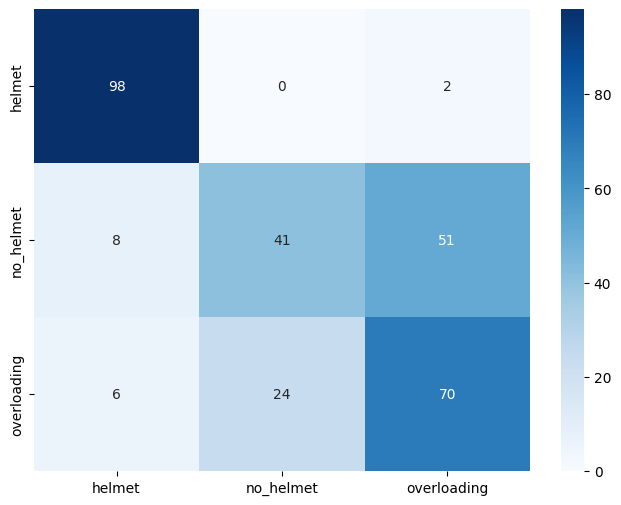

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['helmet', 'no_helmet', 'overloading'], yticklabels=['helmet', 'no_helmet', 'overloading'])

## For using trained model

In [ ]:
class HelmetClassifier:
    def __init__(self, model_path='helmet_model.pth', device=None):
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        # Initialize model
        self.model = convnext_small(num_classes=3)

        # Load saved weights
        checkpoint = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint)
        self.model = self.model.to(self.device)
        self.model.eval()

        # Define image transforms
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

        # Class labels
        self.classes = ['helmet', 'no_helmet', 'overloading']

    def preprocess_image(self, image):
        """Preprocess image for model input"""
        if isinstance(image, str):
            # If input is image path
            image = cv2.imread(image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transforms
        image = self.transform(image).unsqueeze(0)  # Add batch dimension
        return image.to(self.device)

    def predict(self, image, return_confidence=False):
        """
        Predict class for single image
        Args:
            image: Can be image path (str) or numpy array
            return_confidence: If True, returns confidence scores
        """
        # Preprocess image
        processed_image = self.preprocess_image(image)

        # Get prediction
        with torch.no_grad():
            outputs = self.model(processed_image)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

            predicted_class = self.classes[predicted.item()]
            confidence = confidence.item()

        if return_confidence:
            return predicted_class, confidence
        return predicted_class

    def predict_batch(self, images):
        """Predict classes for a batch of images"""
        processed_images = torch.stack([self.preprocess_image(img).squeeze(0)
                                      for img in images])

        with torch.no_grad():
            outputs = self.model(processed_images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(probabilities, 1)

        return [self.classes[p.item()] for p in predicted]

## Testing it

In [ ]:
# Initialize model'
model_path = '/content/best_model.pth'
model_test = convnext_small(num_classes=3)

# Load saved weights
checkpoint = torch.load(model_path, map_location=DEVICE)
model_test.load_state_dict(checkpoint)
model_test = model.to(DEVICE)
model_test.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [ ]:
img_path = '/content/sample_data/nguoi-nuoc-ngoai-thi-bang-lai.jpg'

In [ ]:
def predict_image(image_path, model, device):
        # Define transforms
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)

        # Make prediction
        with torch.no_grad():
            outputs = model(image)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        # Map to class names
        classes = ['helmet', 'no_helmet', 'overloading']
        predicted_class = classes[predicted.item()]
        confidence = confidence.item()

        return predicted_class, confidence

In [ ]:
predicted_class, confidence = predict_image(img_path, model_test, DEVICE)
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

Predicted class: overloading
Confidence: 1.00


# For real-time video

Load vehicle detection model

In [ ]:
model = YOLO('/content/drive/MyDrive/Colab Notebooks/deepLearningProject/best_final.pt')

Load two-wheelers violation

In [ ]:
classifier = HelmetClassifier('/content/drive/MyDrive/Colab Notebooks/deepLearningProject/best_model.pth')

Load number plate detection

In [ ]:
license_plate_model = YOLO('/content/drive/MyDrive/Colab Notebooks/deepLearningProject/plate_recognition_model.pt')

## Đọc video để trích xuất và phân loại.

In [ ]:
def extract_frames(video_path, output_frame_size=(640, 640)):
    """
    Trích xuất các khung hình từ một video.
    video_path: đường dẫn của 1 video

    return: frame_list: danh sách các khung hình được trích xuất
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return []

    frame_list = []
    frame_id = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
          break
        # if frame_id == 150:
        #   break
        resized_frame = cv2.resize(frame, output_frame_size)
        frame_list.append(resized_frame)

        frame_id += 1

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    print(f"Kích thước frame gốc: {frame_width}x{frame_height}")
    cap.release()
    return frame_list

deepSORT for counting vehicle

In [ ]:
from deep_sort_realtime.deepsort_tracker import DeepSort

In [ ]:
# # Khởi tạo thông số video
# output_path = "/content/drive/MyDrive/Colab Notebooks/Images/trafficpolice_count_1.mp4"  # Đường dẫn lưu video kết quả
# def deepSort_tracking(input_path, output_path):
#   frames = extract_frames(input_path)
#   frame_rate = 30  # Số frame trên giây
#   frame_width = 1920
#   frame_height = 1080
#   tracker = DeepSort(max_age=30, n_init=3, max_cosine_distance=0.7)
#   violated_ids = set()
#   # Khởi tạo VideoWriter (sẽ được gán giá trị sau khi có frame đầu tiên)
#   video_writer = None

#   for i, frame in enumerate(frames):
#       motorbike_boxes = []
#       # Chuyển đổi màu sắc từ BGR sang RGB
#       img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#       # Dự đoán bounding box trên từng frame
#       results = model(img)

#       # Hiển thị bounding box trên frame
#       for pred in results[0].boxes:
#           x1, y1, x2, y2 = pred.xyxy[0].cpu().numpy()
#           conf = float(pred.conf.cpu().numpy())
#           class_id = int(pred.cls.cpu().numpy())
#           label = model.names[class_id]
#           if label == 'number_plate' or label == 'blur_number_plate':
#             continue
#           if label == 'motorcycle':
#             motorbike_boxes.append([x1, y1, x2, y2, conf])
#             x_min, y_min, x_max, y_max = map(int, pred.xyxy[0])
#             cropped_frame = img[y_min:y_max, x_min:x_max]
#             plate_results = license_plate_model(cropped_frame)

#             for plate_pred in plate_results[0].boxes:
#                   px1, py1, px2, py2 = map(int, plate_pred.xyxy[0])
#                   cropped_plate = cropped_frame[py1:py2, px1:px2]

#                   cv2.rectangle(img, (x_min + px1, y_min + py1), (x_min + px2, y_min + py2), (0, 0, 255), 2)

#             predicted_class, confidence = classifier.predict(cropped_frame, return_confidence=True)
#             if predicted_class == 'helmet':
#               cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
#             else:
#               cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
#             text = f"{predicted_class} ({confidence:.2f})"
#             text_x, text_y = x_min, y_min
#             cv2.putText(
#               img,
#               text,
#               (text_x, text_y),
#               cv2.FONT_HERSHEY_SIMPLEX,
#               0.5,
#               (255, 0, 0),
#               2
#             )
#           else:
#             x_min, y_min, x_max, y_max = map(int, pred.xyxy[0])
#             cropped_frame = img[y_min:y_max, x_min:x_max]
#             plate_results = license_plate_model(cropped_frame)
#             for plate_pred in plate_results[0].boxes:
#                   px1, py1, px2, py2 = map(int, plate_pred.xyxy[0])
#                   cropped_plate = cropped_frame[py1:py2, px1:px2]
#                   cv2.rectangle(img, (x_min + px1, y_min + py1), (x_min + px2, y_min + py2), (0, 0, 255), 2)
#             cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
#             cv2.putText(img, f'{label}: {conf:.2f}', (int(x1), int(y1) - 10),
#                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

#       # Định dạng lại motorbike_boxes
#       motorbike_boxes_formatted = [
#           ([x1, y1, x2, y2], conf) for x1, y1, x2, y2, conf in motorbike_boxes
#       ]

#       # Cập nhật tracks
#       tracks = tracker.update_tracks(motorbike_boxes_formatted, frame=img)
#       for track in tracks:
#           if not track.is_confirmed():
#               continue
#           track_id = track.track_id
#           ltrb = track.to_ltrb()
#           x1, y1, x2, y2 = map(int, ltrb)
#           crop_frame = img[y1:y2, x1:x2]
#           predicted_class, confidence = classifier.predict(crop_frame, return_confidence=True)
#           if predicted_class != 'helmet':
#             violated_ids.add(track_id)
#       frame_height, frame_width, _ = img.shape
#       text_position = (frame_width - 250, 50)
#       cv2.putText(img, f'Violation: {len(violated_ids)}', text_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
#       # Chuyển đổi màu sắc từ RGB về BGR (để lưu video)
#       img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

#       # Khởi tạo VideoWriter khi có frame đầu tiên
#       if video_writer is None:
#           frame_height, frame_width = img_bgr.shape[:2]
#           fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec để ghi video
#           video_writer = cv2.VideoWriter(output_path, fourcc, frame_rate, (frame_width, frame_height))

#       # Ghi frame vào video
#       video_writer.write(img_bgr)

#   # Giải phóng VideoWriter
#   if video_writer is not None:
#       video_writer.release()

#   print(f"Video đã được lưu tại {output_path}")


0: 640x640 7 cars, 1 number_plate, 103.8ms
Speed: 2.5ms preprocess, 103.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BSD, 1 BSV, 68.8ms
Speed: 5.1ms preprocess, 68.8ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 640)



<ipython-input-21-062b30048e4d>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf = float(pred.conf.cpu().numpy())
<ipython-input-21-062b30048e4d>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_id = int(pred.cls.cpu().numpy())


Streaming output truncated to the last 5000 lines.
Speed: 2.2ms preprocess, 18.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 512x640 1 BSD, 2 BSVs, 14.5ms
Speed: 3.1ms preprocess, 14.5ms inference, 6.3ms postprocess per image at shape (1, 3, 512, 640)

0: 640x352 (no detections), 17.5ms
Speed: 1.9ms preprocess, 17.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x640 2 buss, 17.8ms
Speed: 2.3ms preprocess, 17.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 512x640 1 BSD, 2 BSVs, 15.7ms
Speed: 3.0ms preprocess, 15.7ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 640x352 (no detections), 14.8ms
Speed: 1.9ms preprocess, 14.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x640 2 buss, 18.3ms
Speed: 2.3ms preprocess, 18.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 512x640 1 BSD, 15.6ms
Speed: 3.1ms preprocess, 15.6ms inference, 1.6ms p

In [ ]:
# Khởi tạo thông số video
  # Đường dẫn lưu video kết quả
def deepSort_tracking(input_path, output_path):
  frames = extract_frames(input_path)
  frame_rate = 30  # Số frame trên giây
  frame_width = 1920
  frame_height = 1080
  tracker = DeepSort(max_age=30, n_init=3, max_cosine_distance=0.7)
  violated_ids = set()
  violation_buffer = {}  # Bộ đệm lưu trạng thái nhãn qua các frame
  buffer_size = 10  # Số lượng frame để xét bộ đệm
  violation_threshold = 7
  # processed_ids = set()
  video_writer = None

  for i, frame in enumerate(frames):
      motorbike_boxes = []
      # Chuyển đổi màu sắc từ BGR sang RGB
      img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


      results = model(img)

      for pred in results[0].boxes:
          x1, y1, x2, y2 = pred.xyxy[0].cpu().numpy()
          conf = float(pred.conf.cpu().numpy())
          class_id = int(pred.cls.cpu().numpy())
          label = model.names[class_id]
          if label == 'number_plate' or label == 'blur_number_plate':
            continue
          if label == 'motorcycle':
            motorbike_boxes.append([x1, y1, x2, y2, conf])
            x_min, y_min, x_max, y_max = map(int, pred.xyxy[0])
            cropped_frame = img[y_min:y_max, x_min:x_max]
            plate_results = license_plate_model(cropped_frame)

            for plate_pred in plate_results[0].boxes:
                  px1, py1, px2, py2 = map(int, plate_pred.xyxy[0])
                  cropped_plate = cropped_frame[py1:py2, px1:px2]

                  cv2.rectangle(img, (x_min + px1, y_min + py1), (x_min + px2, y_min + py2), (0, 0, 255), 2)

            predicted_class, confidence = classifier.predict(cropped_frame, return_confidence=True)
            if predicted_class == 'helmet':
              cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            else:
              cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
            text = f"{predicted_class} ({confidence:.2f})"
            text_x, text_y = x_min, y_min
            cv2.putText(
              img,
              text,
              (text_x, text_y),
              cv2.FONT_HERSHEY_SIMPLEX,
              0.5,
              (255, 0, 0),
              2
            )
          else:
            x_min, y_min, x_max, y_max = map(int, pred.xyxy[0])
            cropped_frame = img[y_min:y_max, x_min:x_max]
            plate_results = license_plate_model(cropped_frame)
            for plate_pred in plate_results[0].boxes:
                  px1, py1, px2, py2 = map(int, plate_pred.xyxy[0])
                  cropped_plate = cropped_frame[py1:py2, px1:px2]
                  cv2.rectangle(img, (x_min + px1, y_min + py1), (x_min + px2, y_min + py2), (0, 0, 255), 2)
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(img, f'{label}: {conf:.2f}', (int(x1), int(y1) - 10),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

      # Định dạng lại motorbike_boxes
      motorbike_boxes_formatted = [
          ([x1, y1, x2, y2], conf) for x1, y1, x2, y2, conf in motorbike_boxes
      ]

      # Cập nhật tracks
      tracks = tracker.update_tracks(motorbike_boxes_formatted, frame=img)
      for track in tracks:
          if not track.is_confirmed():
              continue
          track_id = track.track_id
          ltrb = track.to_ltrb()
          x1, y1, x2, y2 = map(int, ltrb)
          crop_frame = img[y1:y2, x1:x2]
          predicted_class, confidence = classifier.predict(crop_frame, return_confidence=True)
          # if predicted_class != 'helmet' and confidence > 0.9:
          #   violated_ids.add(track_id)
          is_violation = predicted_class != 'helmet' and confidence > 0.9
          if track_id not in violation_buffer:
              violation_buffer[track_id] = []
          violation_buffer[track_id].append(is_violation)
          if len(violation_buffer[track_id]) > buffer_size:
              violation_buffer[track_id].pop(0)  # Xóa trạng thái cũ nhất

            # Kiểm tra nếu vượt ngưỡng vi phạm
          if sum(violation_buffer[track_id]) >= violation_threshold:
              violated_ids.add(track_id)
      frame_height, frame_width, _ = img.shape
      text_position = (frame_width - 250, 50)
      cv2.putText(img, f'Violation: {len(violated_ids)}', text_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
      img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

      #video saving
      if video_writer is None:
          frame_height, frame_width = img_bgr.shape[:2]
          fourcc = cv2.VideoWriter_fourcc(*"mp4v")
          video_writer = cv2.VideoWriter(output_path, fourcc, frame_rate, (frame_width, frame_height))
      video_writer.write(img_bgr)


  if video_writer is not None:
      video_writer.release()

  print(f"Video đã được lưu tại {output_path}")

In [ ]:
def deepSort_tracking_id(input_path, output_path):
    # Trích xuất frames từ video
    frames = extract_frames(input_path)
    frame_rate = 30  # Số frame trên giây
    tracker = DeepSort(max_age=30, n_init=3, max_cosine_distance=0.7)
    video_writer = None

    for i, frame in enumerate(frames):
        # Chuyển đổi màu sắc từ BGR sang RGB
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Sử dụng mô hình YOLOv8 để phát hiện bounding boxes
        results = model(img)  # model là YOLOv8 đã được huấn luyện

        # Định dạng lại bounding boxes từ YOLOv8
        detected_boxes = []
        for pred in results[0].boxes:
            x1, y1, x2, y2 = pred.xyxy[0].cpu().numpy()
            conf = float(pred.conf.cpu().numpy())
            detected_boxes.append(([x1, y1, x2, y2], conf))
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        # Cập nhật DeepSort tracker
        tracks = tracker.update_tracks(detected_boxes, frame=img)
        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            ltrb = track.to_ltrb()
            x1, y1, x2, y2 = map(int, ltrb)

            # Vẽ bounding box và gán ID
            # cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(
                img,
                f'ID: {track_id}',
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 0, 0),
                2
            )

        # Chuyển đổi lại từ RGB sang BGR để lưu video
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # Khởi tạo VideoWriter nếu chưa có
        if video_writer is None:
            frame_height, frame_width = img_bgr.shape[:2]
            fourcc = cv2.VideoWriter_fourcc(*"mp4v")
            video_writer = cv2.VideoWriter(output_path, fourcc, frame_rate, (frame_width, frame_height))

        # Ghi frame vào video
        video_writer.write(img_bgr)

    # Đóng VideoWriter
    if video_writer is not None:
        video_writer.release()

    print(f"Video đã được lưu tại {output_path}")

## Modify your input and output file path for tracking and counting

In [ ]:
# tracking with id
input_path = "/content/drive/MyDrive/Colab Notebooks/processed_video/sample_videos/camerahanhtrinh_3.mp4"
output_path = "/content/drive/MyDrive/Colab Notebooks/processed_video/result_videos/camerahanhtrinh3_id.mp4"
deepSort_tracking_id(input_path, output_path)

Kích thước frame gốc: 1920x1080

0: 640x640 11 motorcycles, 37.1ms
Speed: 1.9ms preprocess, 37.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 10 motorcycles, 37.0ms
Speed: 2.2ms preprocess, 37.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 10 motorcycles, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



<ipython-input-21-5eb4e96bd782>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf = float(pred.conf.cpu().numpy())


0: 640x640 11 motorcycles, 29.5ms
Speed: 3.4ms preprocess, 29.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 motorcycles, 29.5ms
Speed: 2.2ms preprocess, 29.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 motorcycles, 23.6ms
Speed: 3.4ms preprocess, 23.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 10 motorcycles, 23.0ms
Speed: 2.0ms preprocess, 23.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 10 motorcycles, 23.0ms
Speed: 2.4ms preprocess, 23.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 10 motorcycles, 23.0ms
Speed: 1.8ms preprocess, 23.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 11 motorcycles, 23.0ms
Speed: 1.8ms preprocess, 23.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 12 motorcycles, 23.0ms
Speed: 

In [ ]:
# Counting violating vehicles
input_path = "/content/drive/MyDrive/Colab Notebooks/processed_video/sample_videos/cam2.mp4"
output_path = "/content/drive/MyDrive/Colab Notebooks/processed_video/result_videos/cam2.mp4"
deepSort_tracking(input_path, output_path)

Kích thước frame gốc: 1280x720

0: 640x640 1 bus, 1 car, 37.1ms
Speed: 1.9ms preprocess, 37.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x608 (no detections), 37.3ms
Speed: 2.1ms preprocess, 37.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)

0: 640x288 (no detections), 24.0ms
Speed: 1.5ms preprocess, 24.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x640 1 bus, 2 cars, 1 motorcycle, 37.1ms
Speed: 3.1ms preprocess, 37.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x288 (no detections), 23.1ms
Speed: 2.3ms preprocess, 23.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 288)



<ipython-input-23-13e12a41ede5>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf = float(pred.conf.cpu().numpy())
<ipython-input-23-13e12a41ede5>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_id = int(pred.cls.cpu().numpy())


Streaming output truncated to the last 5000 lines.
Speed: 2.5ms preprocess, 23.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 1 bus, 2 cars, 1 motorcycle, 2 number_plates, 1 blur_number_plate, 21.3ms
Speed: 2.0ms preprocess, 21.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x224 (no detections), 16.6ms
Speed: 4.7ms preprocess, 16.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 (no detections), 13.0ms
Speed: 1.2ms preprocess, 13.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x480 (no detections), 16.8ms
Speed: 2.1ms preprocess, 16.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x416 (no detections), 17.4ms
Speed: 2.0ms preprocess, 17.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 1 bus, 2 cars, 1 motorcycle, 2 number_plates, 1 blur_number_plate, 21.0ms
Speed: 2.1ms preprocess, 21.0ms inference, 1.7ms po